# Interactive labeling with Jupyter

Adapted from:
- [Pytorch models in modAL workflows](https://modal-python.readthedocs.io/en/latest/content/examples/Pytorch_integration.html)
- [Interactive labeling with Jupyter](https://modal-python.readthedocs.io/en/latest/content/examples/interactive_labeling.html)
- [An Example of Transfer Learning for Image Classification](https://github.com/theevann/amld-pytorch-workshop/blob/master/7-Transfer-Learning.ipynb)

In [1]:
import os
import random
import numpy as np
import cv2

import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet18
import torchmetrics
from torchmetrics import F1Score

from skorch import NeuralNetClassifier

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
matplotlib.rc('font', size=16)

In [2]:
device_id = torch.cuda.current_device()
torch.cuda.get_device_name(device_id)

'Tesla V100-SXM2-32GB'

## The dataset

We set up the initial training set for our classifier.

### 1. Reading data from torchvision

#### Data loading and pre-processing

Here we will create a `Dataset` and corresponding `DataLoader` that find training examples in the following directory structure:

```
dataset/
│
└───train
│     │
│     │───0_diagram
│     │    │   jamin_ed3t4-0015_1.jpg
│     │    │   jamin_ed3t4-0018_1.jpg
│     │    └   ...
│     │
│     └───1_instrument
│     │    │   jamin_ed3t4-0015_2.jpg
│     │    │   jamin_ed3t4-0016_1.jpg
│     │    └   ...
│     │
│     └───2_black
│          │   jamin_ed3t4-0015_2.jpg
│          │   jamin_ed3t4-0016_1.jpg
│          └   ...   
|
└───test
      │
      │───0_diagram
      │    │   jamin_ed4t3f3-419_1.jpg
      │    │   jamin_ed4t3f3-422_1.jpg
      │    └   ...
      │
      └───1_instrument
      │    │   jamin_ed4t3f3-020_2.jpg
      │    │   jamin_ed4t3f3-027_1.jpg
      │    └   ...
      │
      └───2_black
           │   jamin_ed4t3f3-660_1.jpg
           │   jamin_ed4t3f3-660_3.jpg
           └   ...
    
```

In [3]:
# To have deterministic and reproductible sequences for training
torch.manual_seed(999)
np.random.seed(42)
random.seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import *

from torch.utils.data import DataLoader

# Create datasets
train_data = ImageFolder(
    os.path.join(os.getcwd(), "dataset", "train"),
    transform=Compose( # data augmentation
        [Grayscale(num_output_channels=3), 
         Resize((224, 224)), 
         RandomHorizontalFlip(),
         RandomVerticalFlip(),
         ToTensor()
        ]
    )  
)

test_data = ImageFolder(
    os.path.join(os.getcwd(), "dataset", "test"),
    transform=Compose( # data augmentation
        [Grayscale(num_output_channels=3), 
         Resize((224, 224)), 
         RandomHorizontalFlip(), 
         RandomVerticalFlip(),
         ToTensor()
        ]
    )  
)

# Specify corresponding batched data loaders
train_loader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

# Our datasets have three classes:
class_names = train_data.classes
class_names

['0_diagram', '1_instrument', '2_black']

In [5]:
X_train, y_train = next(iter(train_loader))
X_train = X_train.detach().cpu().numpy() # (batch_size_train=512, 3, 224, 224)
y_train = y_train.detach().cpu().numpy() # (batch_size_train=512,)

In [6]:
X_test, y_test = next(iter(test_loader))
X_test = X_test.detach().cpu().numpy() # (batch_size_test=32, 3, 224, 224)
y_test = y_test.detach().cpu().numpy() # (batch_size_test=32,)

### 2. Assembling initial training data for ActiveLearner

In [7]:
# assemble initial data
n_initial = 128
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial = X_train[initial_idx] # (n_initial=128, 3, 224, 224)
y_initial = y_train[initial_idx] # (n_initial=128,)

### 3. Generating the pool

In [8]:
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0) # (batch_size-n_initial=384, 3, 224, 224)
y_pool = np.delete(y_train, initial_idx, axis=0) # (batch_size-n_initial=384, 1)

## Loading a pre-trained model
We will use the ResNet-18 architecture:

In [9]:
model_ft = torchvision.models.resnet18(pretrained=True)
model_ft.fc

Linear(in_features=512, out_features=1000, bias=True)

The last fully connected layer has a 1000 output neurons since it has been trained on the ImageNet task, which has 1000 image classes.
We would like to perform ternary classification (diagram/instrument/black). Therefore, we have to replace the last fully-connected layer to suit our needs (three output units).

In [10]:
in_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(in_features=in_features, out_features=len(class_names))
model_ft.fc

Linear(in_features=512, out_features=3, bias=True)

## Initializing the learner

In [11]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device_type

'cuda'

In [12]:
device = torch.device(device_type)

In [13]:
import sklearn
from sklearn.metrics import f1_score, make_scorer
from skorch.callbacks import EpochScoring

# F1 score
f1 = EpochScoring(scoring=make_scorer(f1_score, average='micro'), 
                  lower_is_better=False, 
                  on_train=True)

# create the classifier
classifier = NeuralNetClassifier(model_ft,
                                 #lr=0.001,
                                 #max_epochs=100,
                                 criterion=nn.CrossEntropyLoss,
                                 optimizer=torch.optim.Adam,
                                 train_split=None,
                                 verbose=0,
                                 callbacks=[f1],
                                 device=device_type)

#### Search for optimized hyperparameters (learning rate and batch size)

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'batch_size': [128, 64, 32, 16, 8, 4]
}

gs = GridSearchCV(estimator=classifier,
                  param_grid=param_grid,
                  scoring=make_scorer(f1_score, average='micro'),
                  refit=False, 
                  cv=3, 
                  verbose=2)

In [15]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ...........................batch_size=128, lr=1e-05; total time=  11.1s
[CV] END ...........................batch_size=128, lr=1e-05; total time=   8.3s
[CV] END ...........................batch_size=128, lr=1e-05; total time=   8.6s
[CV] END ..........................batch_size=128, lr=0.0001; total time=   8.4s
[CV] END ..........................batch_size=128, lr=0.0001; total time=   8.5s
[CV] END ..........................batch_size=128, lr=0.0001; total time=   8.5s
[CV] END ...........................batch_size=128, lr=0.001; total time=   8.4s
[CV] END ...........................batch_size=128, lr=0.001; total time=   8.4s
[CV] END ...........................batch_size=128, lr=0.001; total time=   8.4s
[CV] END ............................batch_size=128, lr=0.01; total time=   8.5s
[CV] END ............................batch_size=128, lr=0.01; total time=   8.5s
[CV] END ............................batch_size=

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1,...
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Linear(in_features=512, out_features=3, bias=True)
  ),
),
             param_grid={'batch_size': [128, 64, 32, 16, 8, 4],
                         'lr': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
             refit=False, scoring=make_scorer(f1_score, average=micro),
             verbose=2)

In [16]:
print(gs.best_score_, gs.best_params_)
classifier.set_params(lr=gs.best_params_['lr'])
classifier.set_params(batch_size=gs.best_params_['batch_size'])
classifier.set_params(verbose=1)

0.9862155388471177 {'batch_size': 128, 'lr': 0.0001}


<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(

#### Initialize the active learner

In [17]:
learner = ActiveLearner(
    estimator=classifier,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

  epoch    f1_score    train_loss     dur
-------  ----------  ------------  ------
      1      0.5078        1.0957  0.1839
      2      1.0000        0.4311  0.1857
      3      1.0000        0.1822  0.1839
      4      1.0000        0.0856  0.1882
      5      1.0000        0.0444  0.1873
      6      1.0000        0.0251  0.2052
      7      1.0000        0.0153  0.2109
      8      1.0000        0.0100  0.1892
      9      1.0000        0.0070  0.1916
     10      1.0000        0.0051  0.2416


In [18]:
n_queries = 10 # The number of queries to the user

## The active learning loop

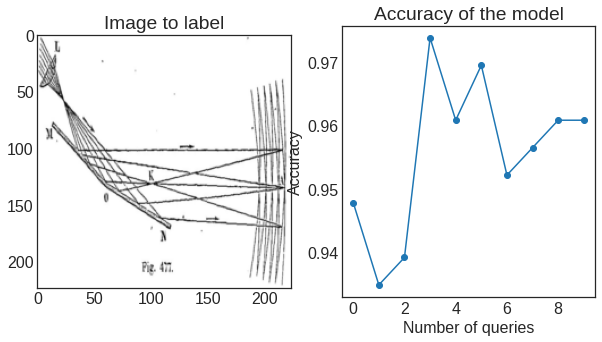

Query no. 10: What is the class of this image?


 0


Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    f1_score    train_loss     dur
-------  ----------  ------------  ------
      1      1.0000        0.0000  0.2190
      2      1.0000        0.0000  0.2143
      3      1.0000        0.0000  0.2128
      4      1.0000        0.0000  0.2122
      5      1.0000        0.0000  0.2141
      6      1.0000        0.0000  0.2134
      7      1.0000        0.0000  0.2131
      8      1.0000        0.0000  0.2142
      9      1.0000        0.0000  0.2131
     10      1.0000        0.0000  0.2141


In [19]:
accuracy_scores = [learner.score(X_test, y_test)]

for i in range(n_queries):
    query_idx, query_instance = learner.query(X_pool) # (1, 3, 224, 224)
    img_to_display = np.squeeze(query_instance, axis=0) # (3, 224, 224)
    img_to_display = img_to_display.transpose((1,2,0)) # (224, 224, 3)
    
    display.clear_output(wait=True)
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 5))
        
        # Sample to label
        plt.subplot(1, 2, 1)
        plt.title('Image to label')
        
        plt.imshow(img_to_display) # (224, 224, 3)
        
        # Accuracy of the model (before adding label)
        plt.subplot(1, 2, 2)
        plt.title('Accuracy of the model')
        plt.plot(range(i+1), accuracy_scores)
        plt.scatter(range(i+1), accuracy_scores)
        plt.xlabel('Number of queries')
        plt.ylabel('Accuracy')
        
        display.display(plt.gcf())
        plt.close('all')
    
    # Ask label to oracle
    print("Query no. %d: What is the class of this image?" % (i + 1))
    y_new = np.array([int(input())], dtype=int)
    
    # Re-train model
    learner.teach(query_instance, y_new) # (1, 1, 28, 28), (1, 1)
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    
    accuracy_scores.append(learner.score(X_test, y_test))

Finally, we can visualize the accuracy during the training.

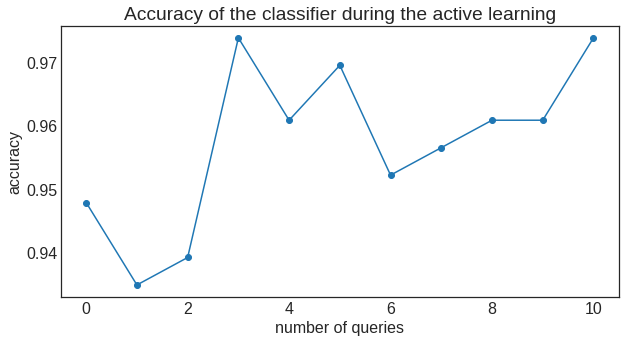

Final accuracy score: 0.97


In [20]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(n_queries+1), accuracy_scores)
    plt.scatter(range(n_queries+1), accuracy_scores)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()
# The final accuracy score
print("Final accuracy score: %.2f" % (learner.score(X_test, y_test)))

## Classification

In [1]:
def imageToTensor(img):
    transform = Compose(
        [ToTensor(),
         Grayscale(num_output_channels=3),
         Resize((224, 224))
        ]
    )
    return transform(img)


def classify(filename):
    img = cv2.imread(filename) # (224, 224, 3)
    img_tensor = imageToTensor(img) # torch.Size([3, 224, 224])    
    img_returned = img_tensor
    img_tensor = img_tensor[np.newaxis, ...] # torch.Size([1, 3, 224, 224])
    img_tensor = img_tensor.to(device)
    preds = classifier_new.predict_proba(img_tensor)
    idx = np.argmax(preds)    
    return filename, img_returned, preds, idx


def display_prediction(filename):    
    (filename, img_returned, preds, idx) = classify(filename)
    # permute turns (rgb, height, width) into (height, width, rgb)
    plt.imshow(img_returned.permute(1, 2, 0))
    plt.xlabel(filename)
    print(f"{filename} is a diagram ({int(preds[0][0]*100)}%) / instrument ({int(preds[0][1]*100)}%) / black ({int(preds[0][2]*100)}%) image")
    print(preds)
    print(f"Predicted class: {class_names[idx]} ({int(preds[0][idx]*100)}%)")

#### Copy the images to the directory of their predicted class

In [51]:
import os
import numpy as np
from pathlib import Path

dataset_name = "dataset/"
classifed_name = "classified/"

# Get list of all files only in the given directory
list_of_files = filter( lambda x: os.path.isfile(os.path.join(dataset_name, x)), os.listdir(dataset_name))

# Sort list of file names by size 
list_of_files = sorted( list_of_files,
                        key =  lambda x: os.stat(os.path.join(dataset_name, x)).st_size)

dataset/ganot_ed13-012_1.jpg is a diagram (0%) / instrument (99%) / black (0%) image
[[7.4576319e-06 9.9999225e-01 2.6549134e-07]]
Predicted class: 1_instrument (99%)


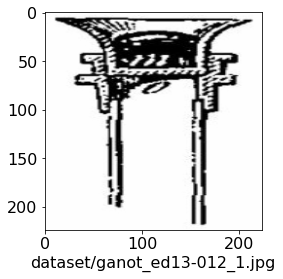

In [23]:
display_prediction("dataset/ganot_ed13-012_1.jpg")

dataset/ganot_ed13-027_1.jpg is a diagram (99%) / instrument (0%) / black (0%) image
[[9.9991047e-01 8.7055014e-05 2.4600079e-06]]
Predicted class: 0_diagram (99%)


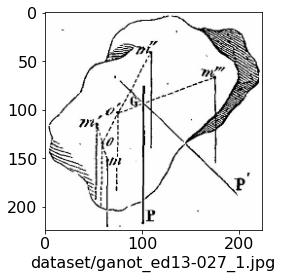

In [24]:
display_prediction("dataset/ganot_ed13-027_1.jpg")

dataset/daguin_t1-0029_1.jpg is a diagram (0%) / instrument (99%) / black (0%) image
[[6.0194160e-04 9.9938011e-01 1.7907952e-05]]
Predicted class: 1_instrument (99%)


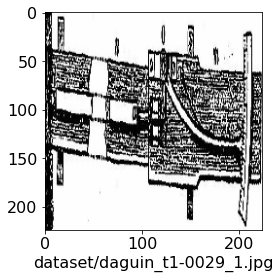

In [25]:
display_prediction("dataset/daguin_t1-0029_1.jpg")

dataset/daguin_t1-0572_3.jpg is a diagram (0%) / instrument (99%) / black (0%) image
[[1.6561881e-07 9.9999988e-01 1.2675827e-08]]
Predicted class: 1_instrument (99%)


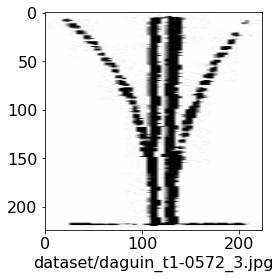

In [26]:
display_prediction("dataset/daguin_t1-0572_3.jpg")

dataset/daguin_t1-0030_1.jpg is a diagram (0%) / instrument (100%) / black (0%) image
[[7.2133480e-11 1.0000000e+00 2.6391722e-10]]
Predicted class: 1_instrument (100%)


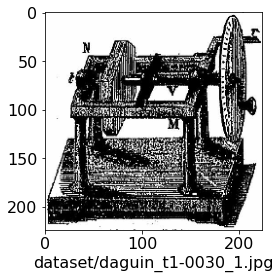

In [27]:
display_prediction("dataset/daguin_t1-0030_1.jpg")

dataset/desains_t1s1-024_1.jpg is a diagram (99%) / instrument (0%) / black (0%) image
[[9.9999666e-01 2.9116645e-06 5.2187090e-07]]
Predicted class: 0_diagram (99%)


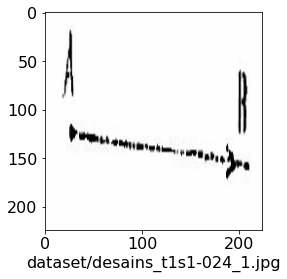

In [28]:
display_prediction("dataset/desains_t1s1-024_1.jpg")

dataset/desains_t1s3-017_4.jpg is a diagram (0%) / instrument (99%) / black (0%) image
[[5.9595538e-07 9.9999928e-01 1.1963269e-07]]
Predicted class: 1_instrument (99%)


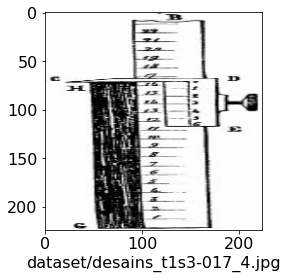

In [29]:
display_prediction("dataset/desains_t1s3-017_4.jpg")

dataset/daguin_t1-0329_2.jpg is a diagram (0%) / instrument (100%) / black (0%) image
[[1.4274654e-10 1.0000000e+00 4.5772408e-09]]
Predicted class: 1_instrument (100%)


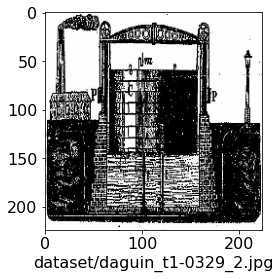

In [30]:
display_prediction("dataset/daguin_t1-0329_2.jpg")

dataset/daguin_t2-164_1.jpg is a diagram (99%) / instrument (0%) / black (0%) image
[[9.9999917e-01 6.3429133e-07 2.5293605e-07]]
Predicted class: 0_diagram (99%)


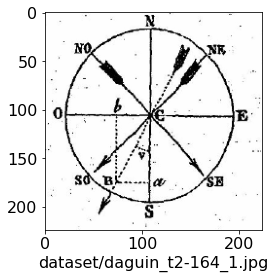

In [31]:
display_prediction("dataset/daguin_t2-164_1.jpg")

dataset/daguin_t3-0300_2.jpg is a diagram (0%) / instrument (5%) / black (94%) image
[[0.00265174 0.05034686 0.94700134]]
Predicted class: 2_black (94%)


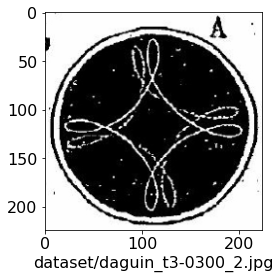

In [32]:
display_prediction("dataset/daguin_t3-0300_2.jpg")

dataset/jamin_t4p2f4-146_1.jpg is a diagram (99%) / instrument (0%) / black (0%) image
[[9.9998939e-01 8.1000717e-06 2.5247484e-06]]
Predicted class: 0_diagram (99%)


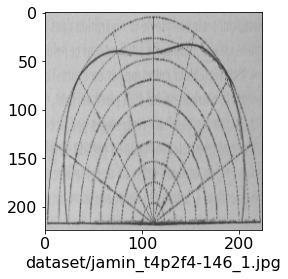

In [33]:
display_prediction("dataset/jamin_t4p2f4-146_1.jpg")

dataset/deguin_ed7-173_3.jpg is a diagram (0%) / instrument (99%) / black (0%) image
[[1.4786805e-04 9.9985003e-01 2.0597590e-06]]
Predicted class: 1_instrument (99%)


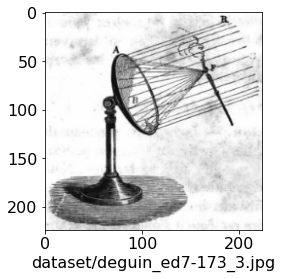

In [34]:
display_prediction("dataset/deguin_ed7-173_3.jpg")

dataset/jamin_t3-196_2.jpg is a diagram (0%) / instrument (100%) / black (0%) image
[[1.4433323e-08 1.0000000e+00 6.7996120e-09]]
Predicted class: 1_instrument (100%)


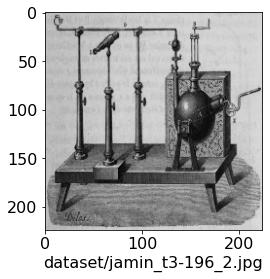

In [35]:
display_prediction("dataset/jamin_t3-196_2.jpg")

dataset/desains_t2s4-815_1.jpg is a diagram (62%) / instrument (37%) / black (0%) image
[[6.2266582e-01 3.7726599e-01 6.8187175e-05]]
Predicted class: 0_diagram (62%)


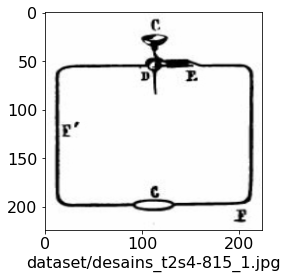

In [36]:
display_prediction("dataset/desains_t2s4-815_1.jpg")

dataset/ganot_ed13-027_2.jpg is a diagram (99%) / instrument (0%) / black (0%) image
[[9.9931264e-01 6.7806232e-04 9.3332847e-06]]
Predicted class: 0_diagram (99%)


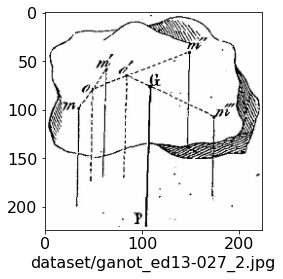

In [37]:
display_prediction("dataset/ganot_ed13-027_2.jpg")

dataset/ganot_ed13-326_1.jpg is a diagram (99%) / instrument (0%) / black (0%) image
[[9.9999750e-01 1.9891513e-06 4.4689307e-07]]
Predicted class: 0_diagram (99%)


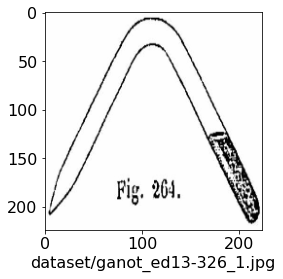

In [38]:
display_prediction("dataset/ganot_ed13-326_1.jpg")

dataset/ganot_ed13-332_1.jpg is a diagram (0%) / instrument (99%) / black (0%) image
[[4.0235205e-04 9.9959606e-01 1.5470723e-06]]
Predicted class: 1_instrument (99%)


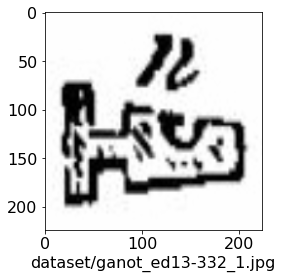

In [39]:
display_prediction("dataset/ganot_ed13-332_1.jpg")

dataset/ganot_ed13-439_2.jpg is a diagram (6%) / instrument (9%) / black (84%) image
[[0.06038356 0.09307799 0.8465385 ]]
Predicted class: 2_black (84%)


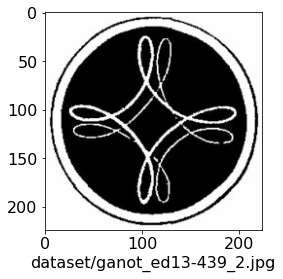

In [40]:
display_prediction("dataset/ganot_ed13-439_2.jpg")

dataset/ganot_ed13-500_1.jpg is a diagram (0%) / instrument (13%) / black (86%) image
[[8.5353048e-04 1.3151838e-01 8.6762804e-01]]
Predicted class: 2_black (86%)


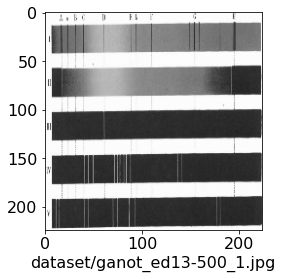

In [41]:
display_prediction("dataset/ganot_ed13-500_1.jpg")

dataset/ganot_ed13-583_3.jpg is a diagram (0%) / instrument (100%) / black (0%) image
[[3.3588754e-09 1.0000000e+00 1.3898592e-08]]
Predicted class: 1_instrument (100%)


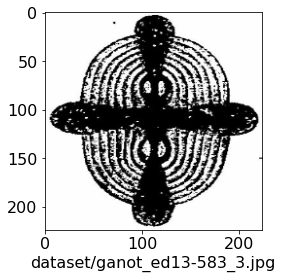

In [42]:
display_prediction("dataset/ganot_ed13-583_3.jpg")

dataset/jamin_ed3t3-0716_8.jpg is a diagram (0%) / instrument (99%) / black (0%) image
[[2.1774475e-03 9.9778903e-01 3.3597444e-05]]
Predicted class: 1_instrument (99%)


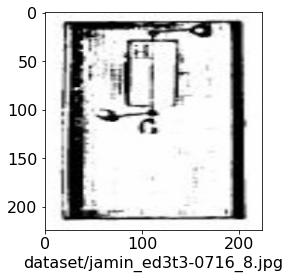

In [43]:
display_prediction("dataset/jamin_ed3t3-0716_8.jpg")

dataset/jamin_ed3t3-0816_1.jpg is a diagram (99%) / instrument (0%) / black (0%) image
[[9.9418455e-01 5.7944995e-03 2.1021538e-05]]
Predicted class: 0_diagram (99%)


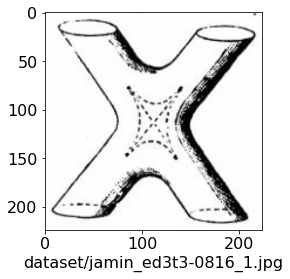

In [44]:
display_prediction("dataset/jamin_ed3t3-0816_1.jpg")

dataset/jamin_ed3t3-0978_1.jpg is a diagram (0%) / instrument (4%) / black (95%) image
[[4.2115684e-04 4.2714391e-02 9.5686448e-01]]
Predicted class: 2_black (95%)


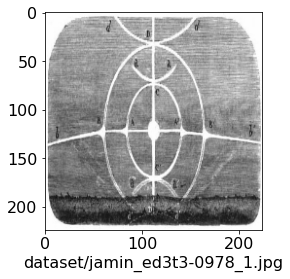

In [45]:
display_prediction("dataset/jamin_ed3t3-0978_1.jpg")

dataset/jamin_ed3t3-0983_1.jpg is a diagram (0%) / instrument (99%) / black (0%) image
[[2.7970113e-06 9.9999380e-01 3.4264076e-06]]
Predicted class: 1_instrument (99%)


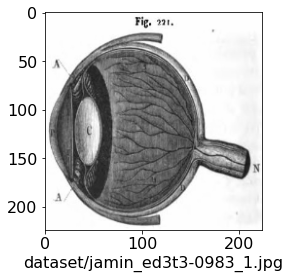

In [46]:
display_prediction("dataset/jamin_ed3t3-0983_1.jpg")

dataset/daguin_t1-0061_1.jpg is a diagram (22%) / instrument (9%) / black (67%) image
[[0.2290692 0.0946603 0.6762705]]
Predicted class: 2_black (67%)


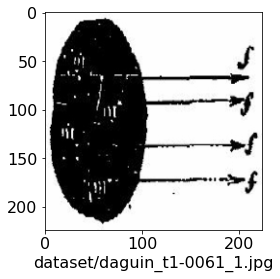

In [47]:
display_prediction("dataset/daguin_t1-0061_1.jpg")

dataset/desains_t2s1-573_1.jpg is a diagram (99%) / instrument (0%) / black (0%) image
[[9.99999046e-01 7.91072523e-07 1.10423926e-07]]
Predicted class: 0_diagram (99%)


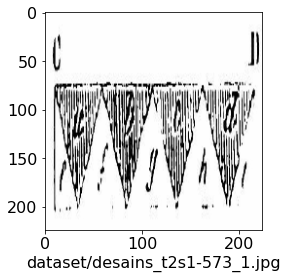

In [48]:
display_prediction("dataset/desains_t2s1-573_1.jpg")

dataset/jamin_t3-600_3.jpg is a diagram (99%) / instrument (0%) / black (0%) image
[[9.9999750e-01 1.4815481e-06 1.0573767e-06]]
Predicted class: 0_diagram (99%)


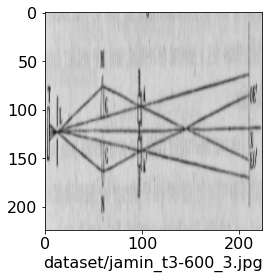

In [49]:
display_prediction("dataset/jamin_t3-600_3.jpg")

dataset/jamin_s3-069_3.jpg is a diagram (99%) / instrument (0%) / black (0%) image
[[9.9999940e-01 4.6374296e-07 9.4146657e-08]]
Predicted class: 0_diagram (99%)


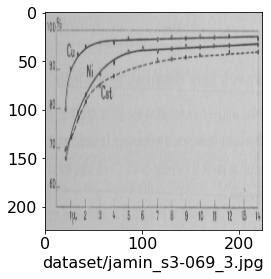

In [50]:
display_prediction("dataset/jamin_s3-069_3.jpg")

## Save the model

In [61]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(classifier, f)